## OpenAI Gym


In [3]:
import gymnasium as gym

In [4]:
env = gym.make("CartPole-v1",render_mode="rgb_array")


In [5]:
envs = gym.envs.registry
envs.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v3', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Walker2d-v5', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5

In [6]:
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

In [7]:
observation,info = env.reset(seed=42)

In [8]:
observation

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [9]:
info

{}

In [10]:
img = env.render()
img.shape

(400, 600, 3)

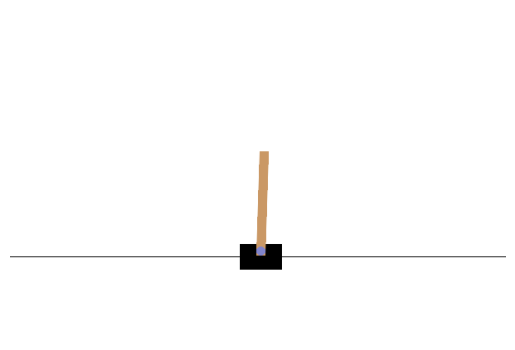

In [11]:
import matplotlib.pyplot as plt

def plot_environment(env):
  img = env.render()
  plt.imshow(img)
  plt.axis("off")

plot_environment(env)

In [12]:
env.action_space

Discrete(2)

In [13]:
action = 0
obs,reward,done,truncated,info = env.step(action)

In [14]:
obs

array([ 0.02727336, -0.20172954,  0.03625453,  0.32351476], dtype=float32)

In [15]:
reward

1.0

In [16]:
done

False

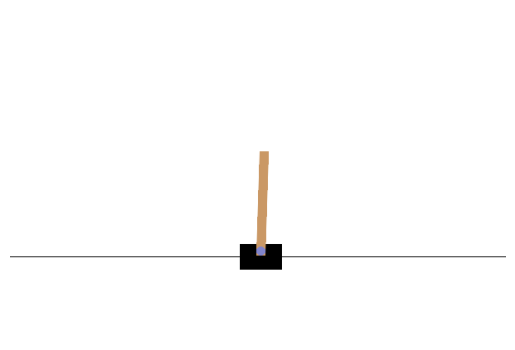

In [17]:
plot_environment(env)

In [18]:
done

False

## A simple hard-coded policy

In [20]:
def basic_policy(obs):
  angle = obs[2]
  return 0 if angle < 0 else 1
total = []
for episode in range(500):
  episode_rewards = 0
  obs,info = env.reset(seed=episode)
  for i in range(200):
    action = basic_policy(obs)
    obs,reward,done,truncated,info = env.step(action)
    episode_rewards += reward
    if done or truncated:
      break
  total.append(episode_rewards)

In [21]:
import numpy as np
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_
print("Average steps survived per episode:",np.mean(total))
print("Variability in episode lengths:",np.std(total))
print("Worst performance:",min(total)),
print("Best performance:",max(total))

Average steps survived per episode: 41.698
Variability in episode lengths: 8.389445512070509
Worst performance: 24.0
Best performance: 63.0


/var/folders/bv/4v76sz4s6hs6w1z89wsx1fd80000gn/T/ipykernel_977/2452969015.py:2: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not hasattr(np, "bool8"):


In [22]:
import matplotlib.animation
from IPython.display import HTML

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy,n_max_steps=200,seed=42):
  frames = []
  env = gym.make("CartPole-v1", render_mode="rgb_array")
  np.random.seed(seed)
  obs,info = env.reset(seed=seed)
  for i in range(n_max_steps):
    frames.append(env.render())
    action=policy(obs)
    obs,reward,done,truncated,info=env.step(action)
    if done or truncated:
      break
  env.close()
  return plot_animation(frames)
anim = show_one_episode(basic_policy)

# Display interactively in notebook / Colab
HTML(anim.to_jshtml())

## Neural Network Policies

In [24]:
import tensorflow as tf

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

In [25]:
def pg_policy(obs):
  left_proba = model.predict(obs[np.newaxis],verbose=0)[0][0]
  return int(np.random.rand()>left_proba)

np.random.seed(42)
anim = show_one_episode(pg_policy)
HTML(anim.to_jshtml())

## Policy Gradients

In [27]:
def play_one_step(env,obs,model,loss_fn):
  with tf.GradientTape() as tape:
    left_proba = model(obs[np.newaxis])    # Model will output near 1 for left and near 0 for right
    action = (tf.random.uniform([1,1]) > left_proba)
    y_target = tf.constant([[1.]]) - tf.cast(action,tf.float32)
    loss = tf.reduce_mean(loss_fn(y_target,left_proba))

  gradients = tape.gradient(loss,model.trainable_variables)
  obs,rewards,done,truncated,info = env.step(int(action))
  return obs,rewards,done,truncated,gradients


In [28]:
def play_multiple_episodes(env,n_episodes,n_max_steps,model,loss_fn):
  all_rewards = []
  all_grads = []
  for episode in range(n_episodes):
    current_rewards = []
    current_grads = []
    obs,info = env.reset()
    for step in range(n_max_steps):
      obs,rewards,done,truncated,gradients = play_one_step(
              env,obs,model,loss_fn)
      current_rewards.append(rewards)
      current_grads.append(gradients)
      if done or truncated :
        break
    all_rewards.append(current_rewards)
    all_grads.append(current_grads)

  return all_rewards,all_grads


In [29]:
def discount_rewards(rewards,discount_factor):
  discounted = np.array(rewards)
  for step in range(len(rewards)-2,-1,-1):
    discounted[step] += discounted[step+1] * discount_factor
  return discounted

def discount_and_normalize_rewards(all_rewards,discount_factor):
  all_discounted_rewards = [discount_rewards(rewards,discount_factor)
                                    for rewards in all_rewards]
  flat_rewards = np.concatenate(all_discounted_rewards)
  reward_mean = flat_rewards.mean()
  reward_std = flat_rewards.std()
  return [(discounted_rewards - reward_mean)/reward_std
             for discounted_rewards in all_discounted_rewards]

In [30]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [31]:
discount_and_normalize_rewards([[10, 0, -50]], discount_factor=0.8)

[array([ 1.32350128, -0.23017414, -1.09332714])]

In [32]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [33]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
obs,info = env.reset(seed=42)


In [34]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [35]:
mean_rewards = []
for iteration in range(n_iterations):
    all_rewards,all_grads = play_multiple_episodes(env,n_episodes_per_update,n_max_steps,
                                                 model,loss_fn)
    mean_reward = sum(map(sum,all_rewards))/n_episodes_per_update
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
        f" mean rewards: {mean_reward:.1f}", end="")
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
      mean_grads = tf.reduce_mean(
          [final_reward * all_grads[episode_index][step][var_index]
           for episode_index,final_rewards in enumerate(all_final_rewards)
           for step,final_reward in enumerate(final_rewards)],axis=0)
      all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads,model.trainable_variables))


Iteration: 150/150, mean rewards: 180.9

In [36]:
np.random.seed(42)
anim = show_one_episode(pg_policy)
HTML(anim.to_jshtml())

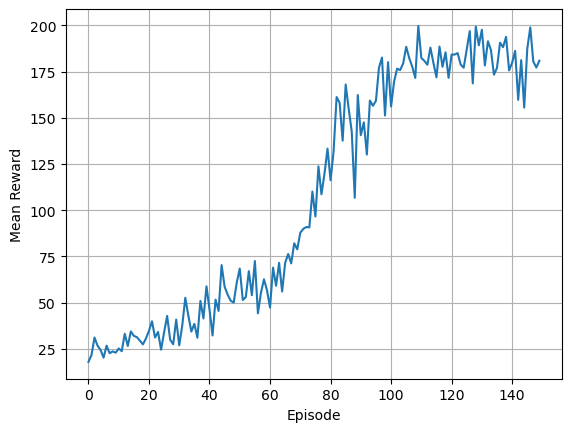

In [37]:
plt.plot(mean_rewards)
plt.grid()
plt.xlabel("Episode")
plt.ylabel("Mean Reward")
plt.show()

## Markov Chains

In [39]:
np.random.seed(42)

transition_probabilities = [   # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to s0, s1, s2, s3
        [0.0, 1.0, 0.0, 0.0],  # from s2 to s0, s1, s2, s3
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to s0, s1, s2, s3

n_max_steps =1000
terminal_states = [3]

def run_chain(start_state):
    current_state = start_state
    for i in range(n_max_steps):
        print(current_state , end=" ")
        if current_state in terminal_states:
            break
        current_state = np.random.choice(
            range(len(transition_probabilities)),
            p = transition_probabilities[current_state]
        )
    print()
for i in range(10):
    print(f"Run #{i} : ",end="")
    run_chain(start_state=0)
        

Run #0 : 0 0 3 
Run #1 : 0 1 2 1 2 1 2 1 2 1 3 
Run #2 : 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #3 : 0 3 
Run #4 : 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #5 : 0 1 3 
Run #6 : 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #7 : 0 0 0 1 2 1 2 1 3 
Run #8 : 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #9 : 0 0 0 1 2 1 3 


## Markov Decision Process

In [41]:
transition_probabilities = [ # shape=[s, a, s']
    [[1.0, 0.0, 0.0],[0.7,0.3,0.0], None],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1]],
    [None, [0.8, 0.0, 0.2],None]   
]

rewards = [  # shape=[s, a, s']
    [[0.0,0.0,0.0],[+10,0.0,0.0],[0.0,0.0,0.0]],
    [[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,-50]],
    [[0.0,0.0,0.0],[+40,0.0,0.0],[0.0,0.0,0.0]]
]
possible_actions = [[0,1],[0,2],[1]]

In [42]:
print(transition_probabilities[1][0][0])

0.0


In [43]:
print(rewards[1][0][0])

0.0


In [44]:
print(possible_actions[1])

[0, 2]


## Q-Value Iteration

In [46]:
Q_values = np.full((3,3),-np.inf)

In [47]:
Q_values

array([[-inf, -inf, -inf],
       [-inf, -inf, -inf],
       [-inf, -inf, -inf]])

In [48]:
for state , actions in enumerate(possible_actions):
    Q_values[state,actions] = 0.0

In [49]:
Q_values

array([[  0.,   0., -inf],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [50]:
# This code for just one iteration for cross checking with mannual calculations
gamma = 0.9
history1 = []
for i in range(1):
    Q_prev = Q_values.copy()
    print(Q_prev)
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s,a] = np.sum([transition_probabilities[s][a][sp]
                                     *(rewards[s][a][sp] + gamma * Q_prev[sp].max())
                                    for sp in range(3)])



[[  0.   0. -inf]
 [  0. -inf   0.]
 [-inf   0. -inf]]


In [51]:
Q_values

array([[  0.,   7., -inf],
       [  0., -inf, -50.],
       [-inf,  32., -inf]])

In [52]:
Q_values.argmax(axis = 1)

array([1, 0, 1])

In [53]:
Q_values = np.full((3,3),-np.inf)

In [54]:
for state , actions in enumerate(possible_actions):
    Q_values[state,actions] = 0.0

In [55]:
gamma = 0.9
history1 = []
for i in range(100):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s][a] = np.sum([transition_probabilities[s][a][sp]
                                     *(rewards[s][a][sp] + gamma * Q_prev[sp].max())
                                    for sp in range(3)])
history1 = np.array(history1)

In [56]:
Q_values

array([[17.13950218, 19.04389333,        -inf],
       [ 0.15413936,        -inf,  0.17126798],
       [       -inf, 55.74585534,        -inf]])

In [57]:
Q_values.argmax(axis = 1) #optimal action for each state

array([1, 2, 1])

## Q-Learning

In [59]:
def step(state,action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0,1,2],p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [60]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [61]:
Q_values = np.full((3,3), -np.inf)
for state, action in enumerate(possible_actions):
    Q_values[state][action] = 0

In [62]:
alpha0 = 0.05
decay = 0.005
gamma = 0.9
state = 0
history2 = []

for i in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state,action)
    next_value = Q_values[next_state].max()
    alpha = alpha0 / (1 + i * decay)
    Q_values[state,action] *= 1 - alpha
    Q_values[state,action] += alpha * (reward + gamma * next_value)
    state = next_state
history2 = np.array(history2)

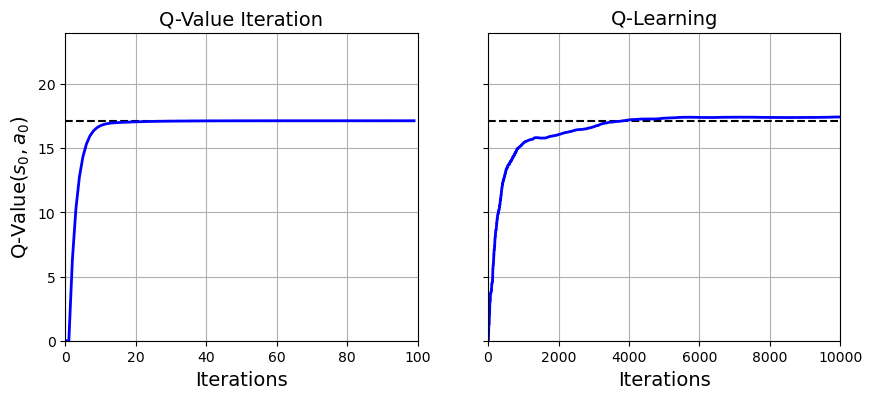

In [63]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (100, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)


In [64]:
true_Q_value = history1[-1, 0, 0]
true_Q_value

17.139500152192976

## Deep Q-Network

In [114]:
n_outputs = 2
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32,activation="elu"),
    tf.keras.layers.Dense(32,activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

In [116]:
def epsilon_greedy_policy(state,epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis],verbose = 0)[0]
        return Q_values.argmax()

In [118]:
class ReplayBuffer:
    def __init__(self):
        self.experiences = []
        self.max_size = 2000
        self.index = 0

    def add_experience(self,state, action, reward, next_state, done, truncated):
        experience = (state, action, reward, next_state, done, truncated)

        if len(self.experiences) < self.max_size:
            self.experiences.append(experience)

        else:
            self.experiences[self.index] = experience
            self.index = (self.index + 1) % self.max_size

    def get_random_batch(self, batch_size=32):
        if len(self.experiences) < batch_size:
            return None
        indices = np.random.choice(len(self.experiences), batch_size, replace=False)
        batch = [self.experiences[i] for i in indices]
    
        # Unpack the batch
        states = np.array([exp[0] for exp in batch])
        actions = np.array([exp[1] for exp in batch])
        rewards = np.array([exp[2] for exp in batch])
        next_states = np.array([exp[3] for exp in batch])
        dones = np.array([exp[4] for exp in batch])
        truncateds = np.array([exp[5] for exp in batch])
    
        return states, actions, rewards, next_states, dones, truncateds

    # def print_buffer(self):
    #     print(f"Buffer size: {len(self.experiences)}/{self.max_size}")
    #     print(f"Current index: {self.index}")
    #     for i, exp in enumerate(self.experiences):
    #         state, action, reward, next_state, done, truncated = exp
    #         print(f"  [{i}]: state={state}, action={action}, reward={reward}")
    #     print()


In [120]:
# dummy_experiences = [
#     ([1, 2], 0, 10, [1.1, 2.1], False, False),  
#     ([2, 3], 1, 20, [2.1, 3.1], False, False),    
#     ([3, 4], 0, 30, [3.1, 4.1], False, False),  
#     ([4, 5], 1, 40, [4.1, 5.1], False, False),  
#     ([5, 6], 0, 50, [5.1, 6.1], True, False),   
#     ([6, 7], 1, 60, [6.1, 7.1], False, False),  
#     ([7, 8], 0, 70, [7.1, 8.1], False, False),  
#     ([8, 9], 1, 80, [8.1, 9.1], False, True),   
# ]

In [122]:
# buffer = ReplayBuffer()
# for i, exp in enumerate(dummy_experiences):
#     print(f"Adding experience {i}: state={exp[0]}, reward={exp[2]}")
#     buffer.add_experience(*exp)
#     buffer.print_buffer()


In [124]:
replay_buffer = ReplayBuffer()

In [126]:
def play_one_step(env,state,epsilon):
    action = epsilon_greedy_policy(state , epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.add_experience(state, action, reward, next_state, done, truncated)
    return next_state , reward , done , truncated ,info

In [128]:
env.reset()
rewards = []
best_score = 0

In [129]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.MeanSquaredError()

def training_step(batch_size):
    experiences = replay_buffer.get_random_batch(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states,verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1 - (dones | truncateds)
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1,1)
    mask = tf.one_hot(actions,n_outputs)

    with tf.GradientTape() as tape :
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask , axis=1 ,keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values,Q_values))
    grads = tape.gradient(loss , model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    

In [132]:
for episode in range(600):
    obs,info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    if episode >= 50:
        training_step(batch_size)
model.set_weights(best_weights)

Episode: 600, Steps: 174, eps: 0.010

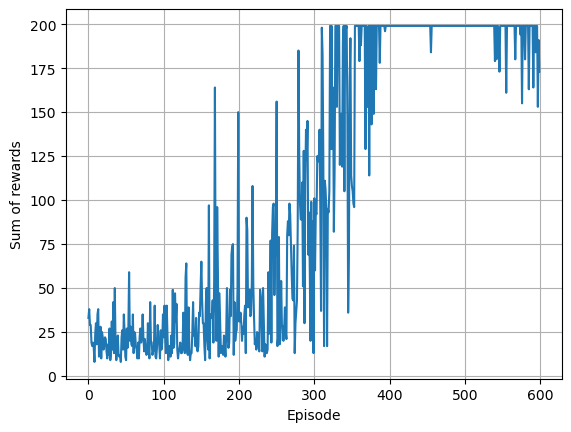

In [134]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.grid(True)

In [136]:
# np.random.seed(42)
anim = show_one_episode(lambda state: epsilon_greedy_policy(state, epsilon=0))
HTML(anim.to_jshtml())

## Fixed Q-Value Targets

In [193]:
n_outputs = 2
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32,activation="elu"),
    tf.keras.layers.Dense(32,activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

In [195]:
target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [197]:
def epsilon_greedy_policy(state,epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis],verbose=0)[0]
        return Q_values.argmax()

In [199]:
class ReplayBuffer:
    def __init__(self):
        self.experiences = []
        self.max_size = 2000
        self.index = 0

    def add_experience(self,state, action, reward, next_state, done, truncated):
        experience = (state, action, reward, next_state, done, truncated)

        if len(self.experiences) < self.max_size:
            self.experiences.append(experience)

        else:
            self.experiences[self.index] = experience
            self.index = (self.index + 1) % self.max_size
            
    def get_random_batch(self,batch_size=32):
        if len(self.experiences) < batch_size:
            return None
        indices = np.random.choice(len(self.experiences), batch_size, replace=False)
        batch = [self.experiences[i] for i in indices]

        states = np.array([exp[0] for exp in batch])
        actions = np.array([exp[1] for exp in batch])
        rewards =  np.array([exp[2] for exp in batch])
        next_states =  np.array([exp[3] for exp in batch])
        dones =  np.array([exp[4] for exp in batch])
        truncateds =  np.array([exp[5] for exp in batch])

        return states, actions, rewards, next_states, dones, truncateds


In [201]:
replay_buffer = ReplayBuffer()

In [203]:
def play_one_step(env,state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.add_experience(state,action,reward,next_state,done,truncated)
    return next_state, reward, done, truncated, info  

In [205]:
env.reset()
rewards = []
best_score = 0
batch = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.MeanSquaredError()

def training_step(batch_size):
    experiences = replay_buffer.get_random_batch(batch_size)
    states ,actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = target.predict(next_states,verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)  #best action for each experience
    runs = 1 - (dones | truncateds)
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1,1)
    mask = tf.one_hot(actions,n_outputs)

    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask ,axis=1,keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values,all_Q_values))
    grads =  tape.gradient(loss , model.trainable_variables)
    optimizer.apply_gradients(zip(loss, model.trainable_variables))

In [207]:
for episode in range(600):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode/500 ,0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)
        

Episode: 52, Steps: 32, eps: 0.898

TypeError: Cannot iterate over a scalar tensor.